<a href="https://colab.research.google.com/github/divyeeee/GAN-from-scratch/blob/main/SimpleGAN_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GAN starter code
Corresponding tutorial: [https://youtu.be/_pIMdDWK5sc](https://youtu.be/_pIMdDWK5sc)

In [ ]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 836.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 45.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlin

In [ ]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

import pytorch_lightning as pl


random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE=128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

In [ ]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data",
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [ ]:
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [ ]:
# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]

    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.LeakyRelU(x)
        x = x.view(-1, 64, 7, 7)  #256

        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)

        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)

        # Convolution to 28x28 (1 feature map)
        return self.conv(x)

NameError: name 'nn' is not defined

In [ ]:
# TODO: GAN
class GAN(pl.LightningModule):
  def __init__(self, automatic_optimization = False,latent_dim=100,lr=0.0002):
    super().__init__()
    self.save_hyperparameters()
    self.automatic_optimization = False  # Disable automatic optimization

    self.generator = Generator(latent_dim=self.hparams.latent_dim)
    self.discriminator=Discriminator()

    # random noise
    self.validation_z = torch.randn(6, self.hparams.latent_dim)

  def forward(self, z):
    return self.generator(z)

  def adversarial_loss(self,y_hat,y):
    return F.binary_cross_entropy(y_hat,y)

  def training_step(self,batch,batch_idx): # Remove optimizer_idx
    # Access your optimizers with
    opt_g, opt_d = self.optimizers()

    real_imgs,_=batch

    # sample noise
    z=torch.randn(real_imgs.shape[0],self.hparams.latent_dim)
    z = z.type_as(real_imgs)

    # train generator : max log(D(G(z)))
    fake_imgs = self(z)
    y_hat = self.discriminator(fake_imgs)

    y=torch.ones(real_imgs.size(0),1)
    y=y.type_as(real_imgs)

    g_loss = self.adversarial_loss(y_hat,y)

    # Manual optimization for generator
    opt_g.zero_grad()
    self.manual_backward(g_loss) # Use manual_backward to calculate gradients
    opt_g.step()

    log_dict = {"g_loss": g_loss}


    # train discriminator:max log (D(x)) + log(1-D(G(z)))
    # how well can it label as real
    y_hat_real = self.discriminator(real_imgs)
    y_real = torch.ones(real_imgs.size(0),1)
    y_real = y_real.type_as(real_imgs)
    real_loss = self.adversarial_loss(y_hat_real,y_real)
    y_hat_fake = self.discriminator(self(z).detach())
    y_fake = torch.zeros(real_imgs.size(0),1)
    y_fake = y_fake.type_as(real_imgs)

    fake_loss = self.adversarial_loss(y_hat_fake,y_fake)
    d_loss = (real_loss + fake_loss)/2

    # Manual optimization for discriminator
    opt_d.zero_grad()
    self.manual_backward(d_loss) # Use manual_backward to calculate gradients
    opt_d.step()

    log_dict = {"d_loss":d_loss}
    # Merge the logs (you can choose how to combine them)
    log_dict.update({"g_loss": g_loss})
    return {"loss": d_loss, "progress_bar": log_dict, "log": log_dict} # Choose which loss to return or combine them


  def configure_optimizers(self):
    lr = self.hparams.lr
    opt_g = torch.optim.Adam(self.generator.parameters(),lr=lr)
    opt_d =  torch.optim.Adam(self.discriminator.parameters(),lr=lr)
    return [opt_g,opt_d],[] # empty list if we use a scheduler as well?

  def plot_imgs(self):
    z = self.validation_z.type_as(self.generator.lin1.weight) # type_as function loads it into gpu?
    sample_imgs = self(z).cpu() # if not then cpu

    print('epoch',self.current_epoch)
    fig = plt.figure()
    for i in range(sample_imgs.size(0)):
      plt.subplot(2,3,i+1)
      plt.tight_layout()
      plt.imshow(sample_imgs.detach()[i,0,:,:],cmap = 'gray_r',interpolation = 'none')
      plt.title("Generated Data")
      plt.xticks([])
      plt.yticks([])
      plt.axis('off')
    plt.show()

  def on_train_epoch_end(self):
    self.plot_imgs()

In [ ]:
dm = MNISTDataModule()
model = GAN()


epoch 0


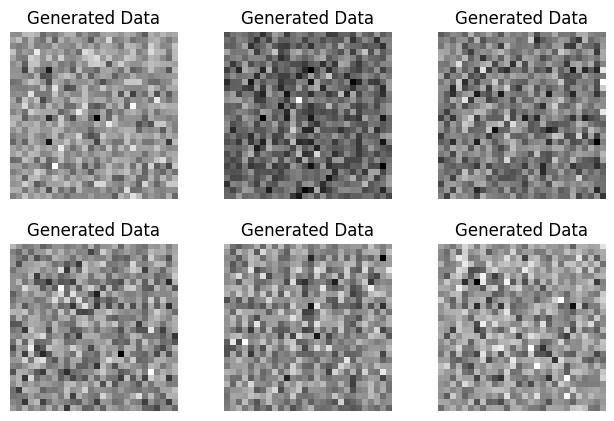

In [ ]:
model.plot_imgs()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 358 K  | train
1 | discriminator | Discriminator | 21.4 K | train
--------------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

epoch 0


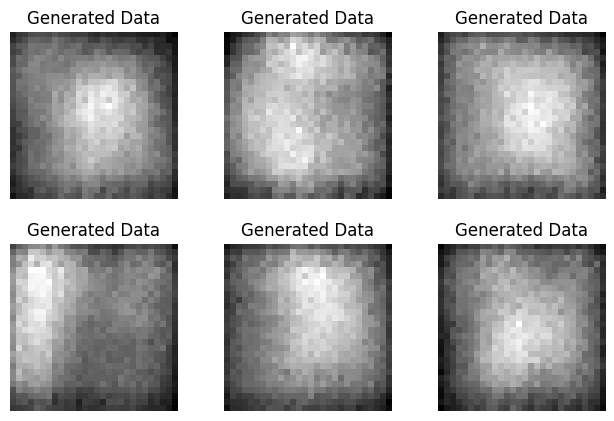

epoch 1


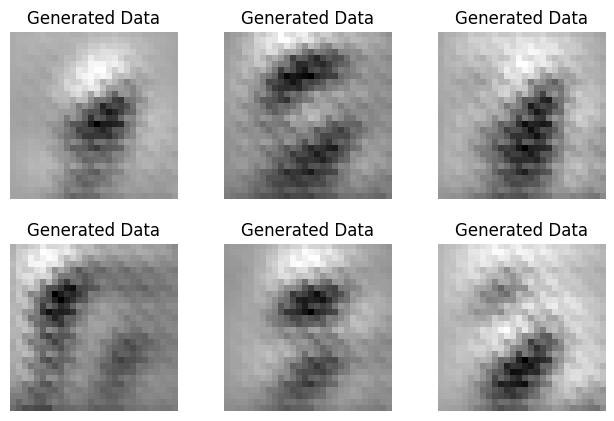

epoch 2


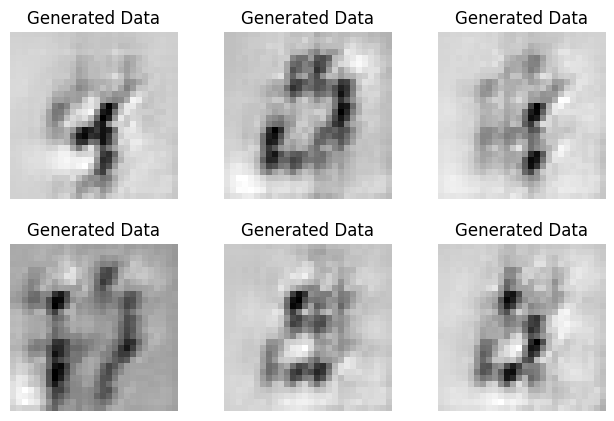

epoch 3


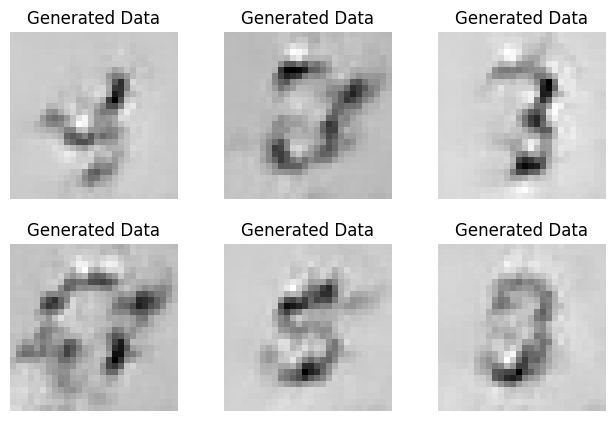

epoch 4


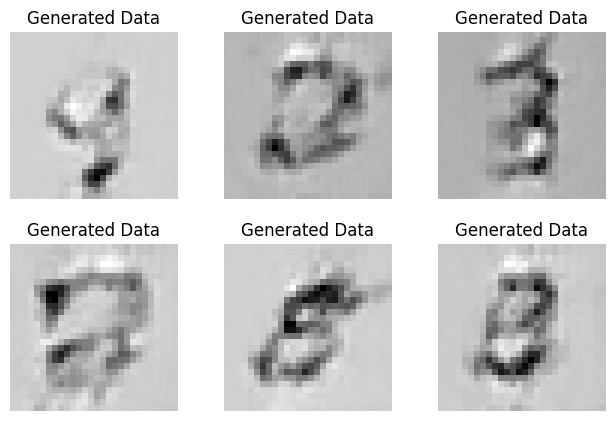

epoch 5


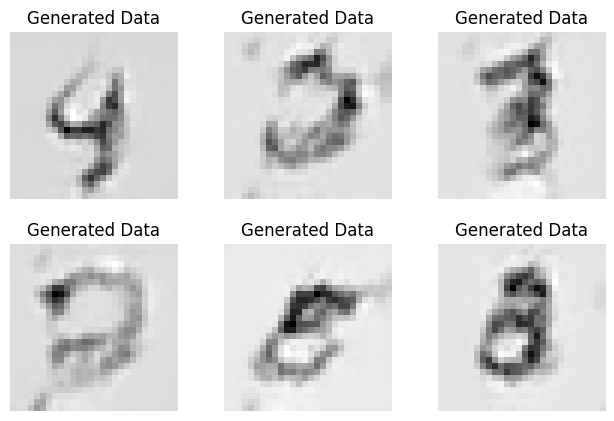

epoch 6


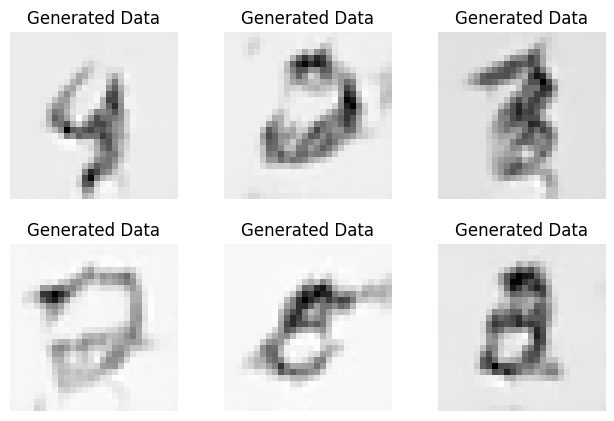

epoch 7


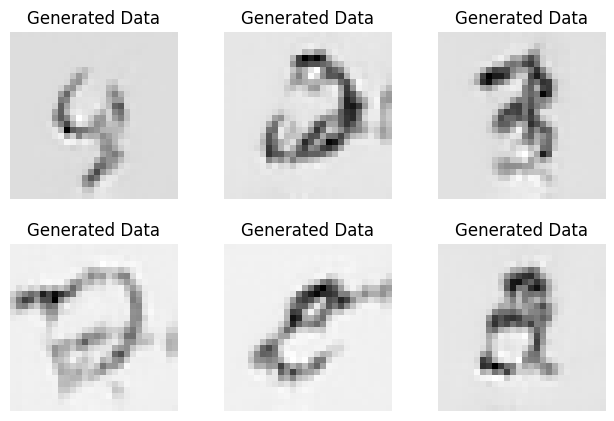

epoch 8


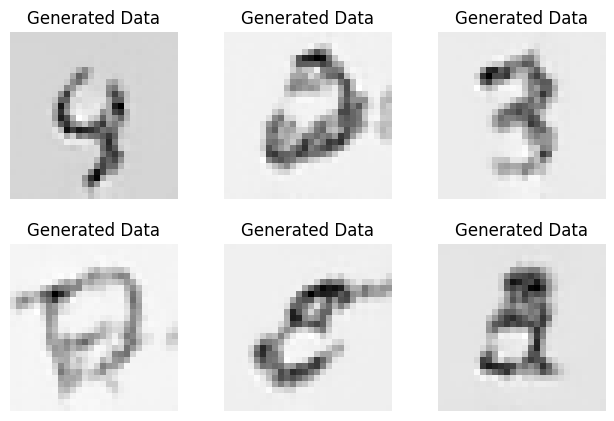

epoch 9


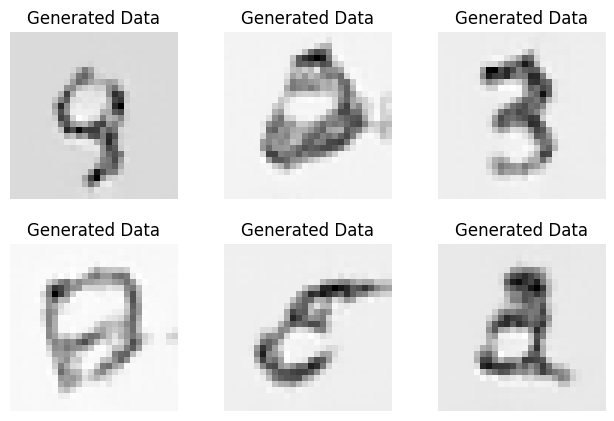

epoch 10


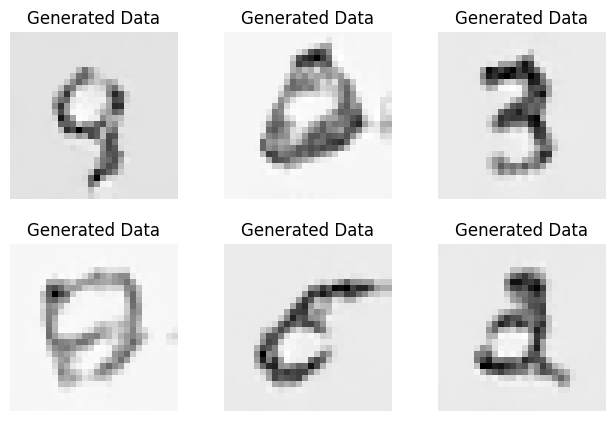

epoch 11


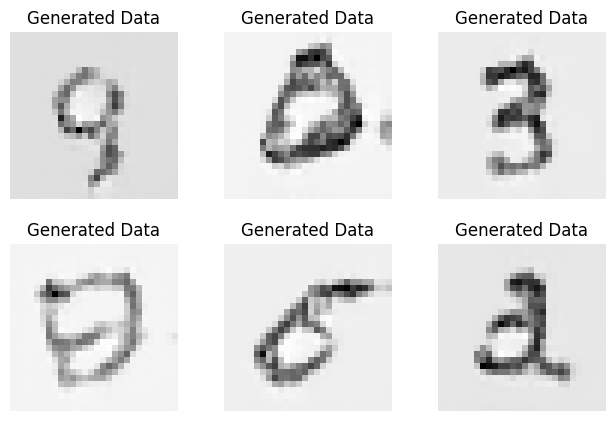

epoch 12


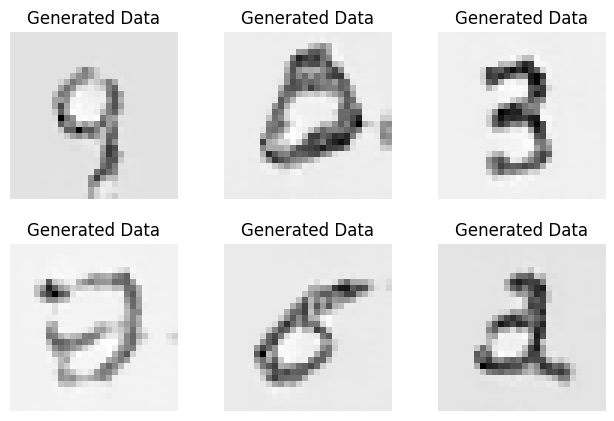

epoch 13


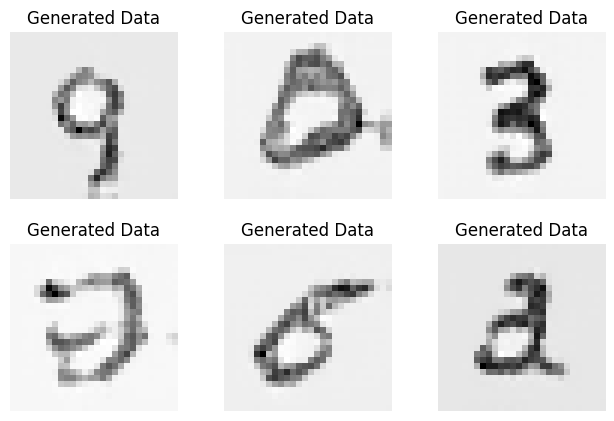

epoch 14


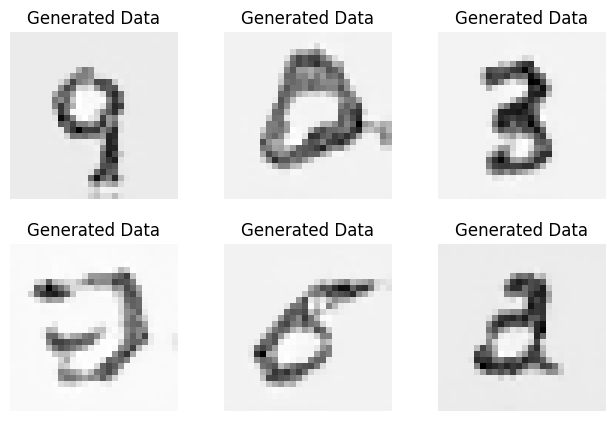

epoch 15


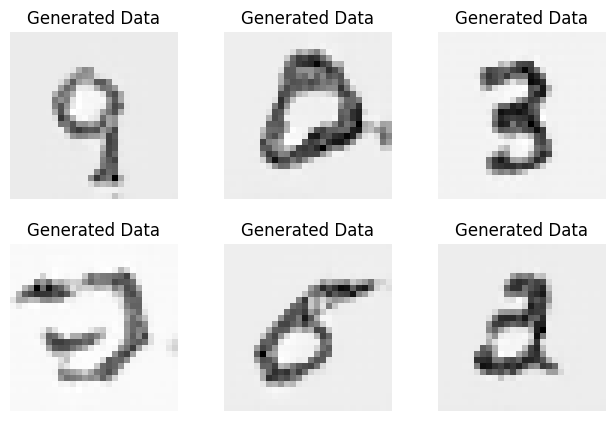

epoch 16


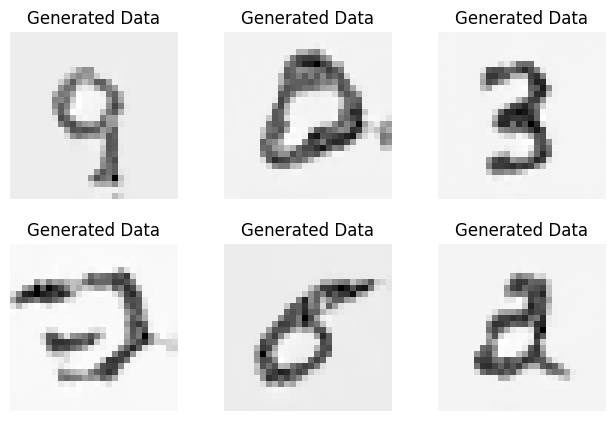

epoch 17


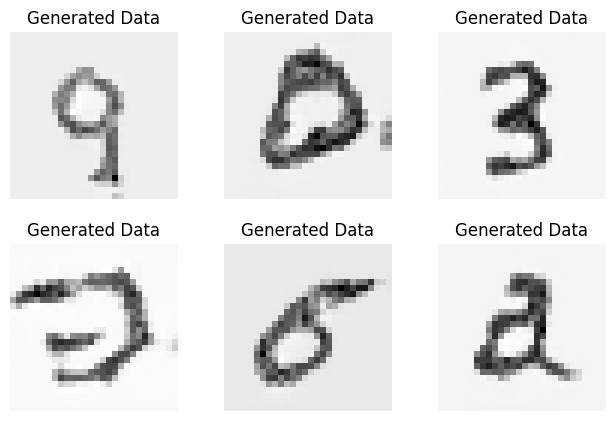

epoch 18


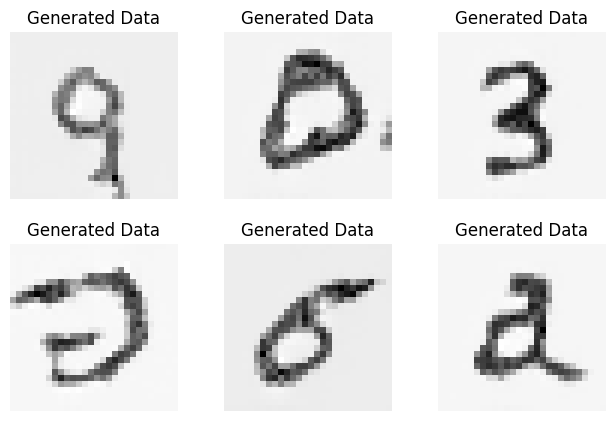

epoch 19


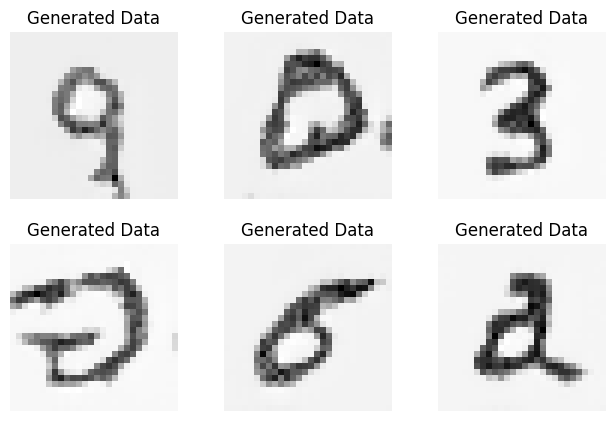

epoch 20


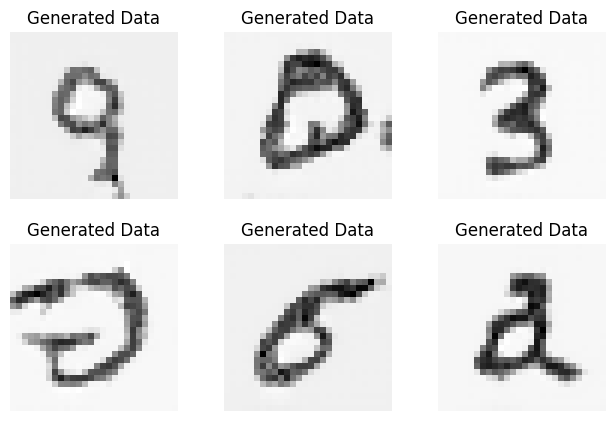

epoch 21


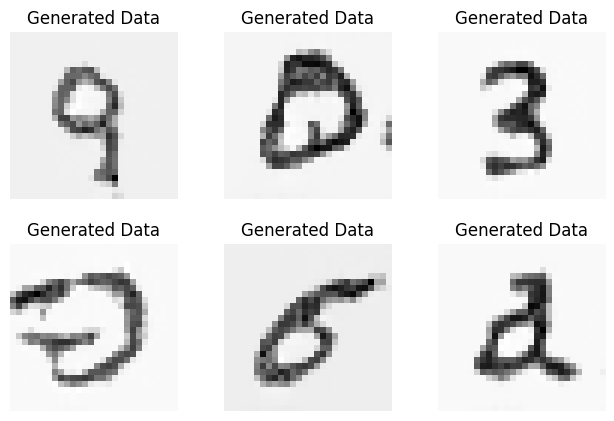

epoch 22


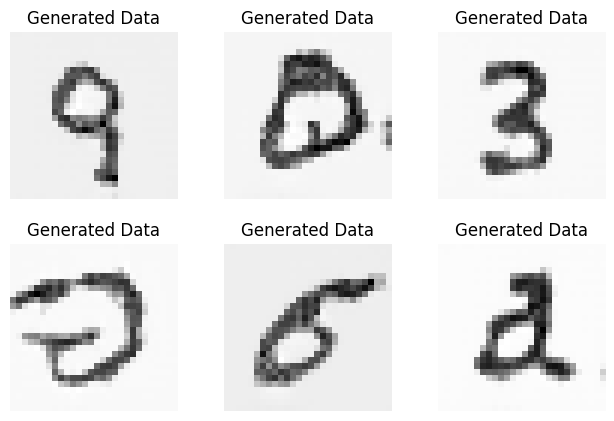

epoch 23


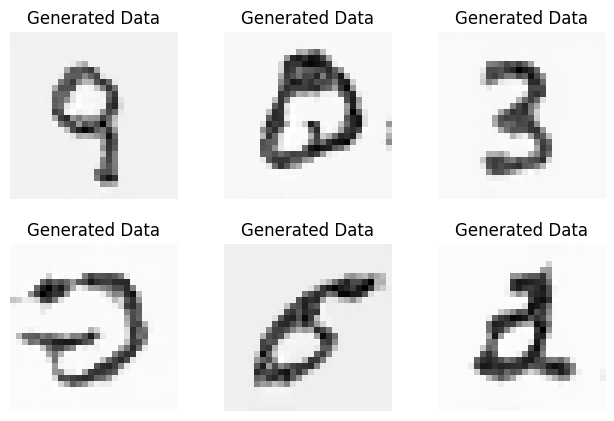

epoch 24


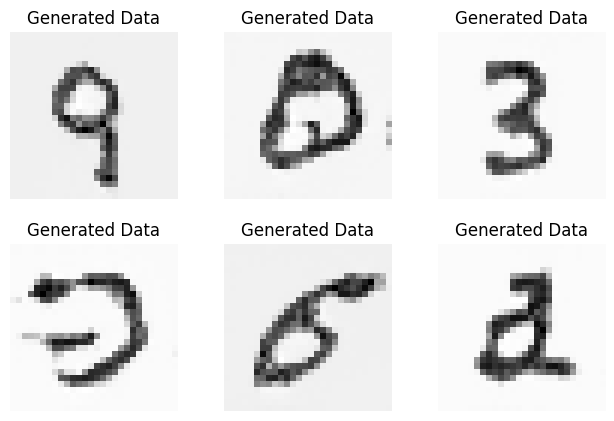

epoch 25


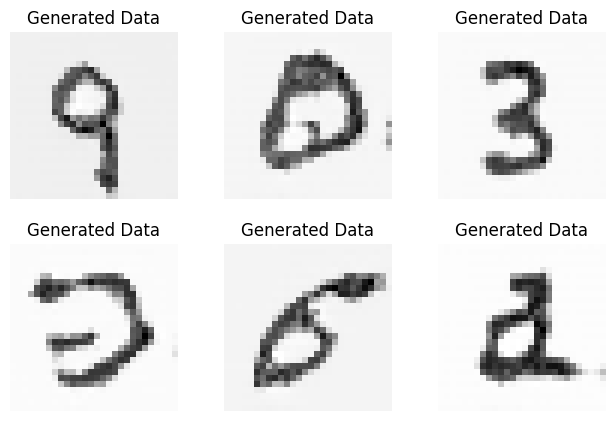

epoch 26


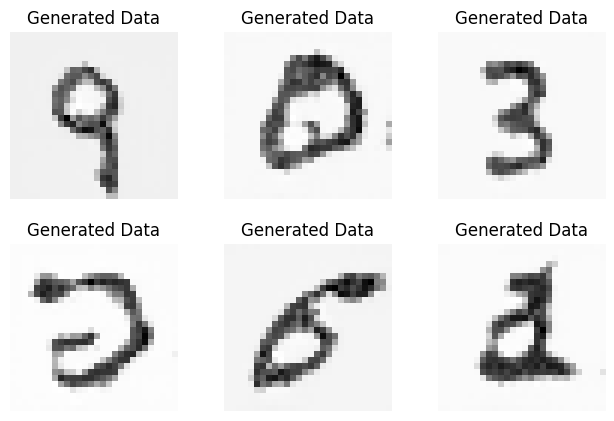

epoch 27


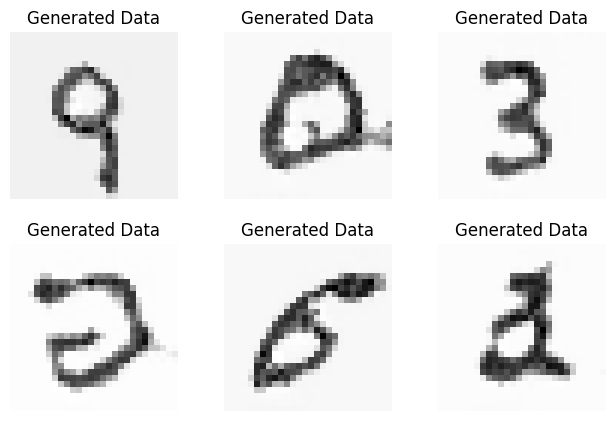

epoch 28


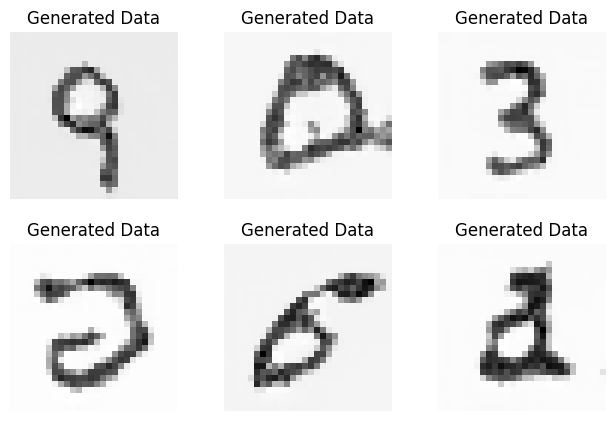

epoch 29


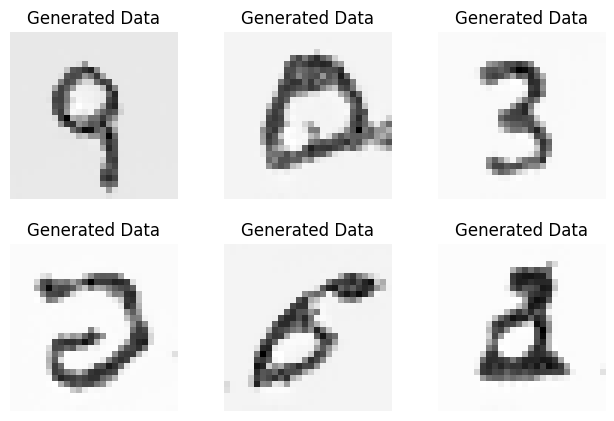

epoch 30


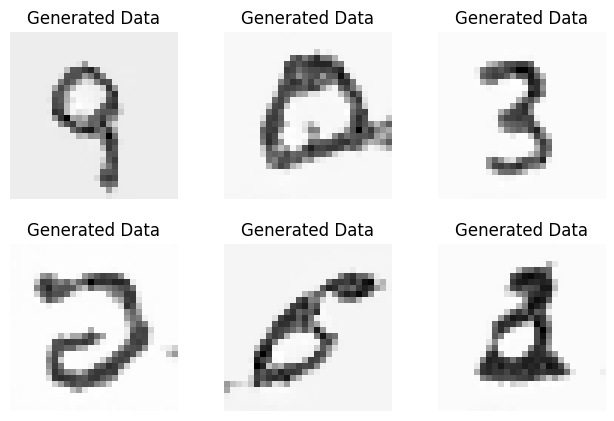

epoch 31


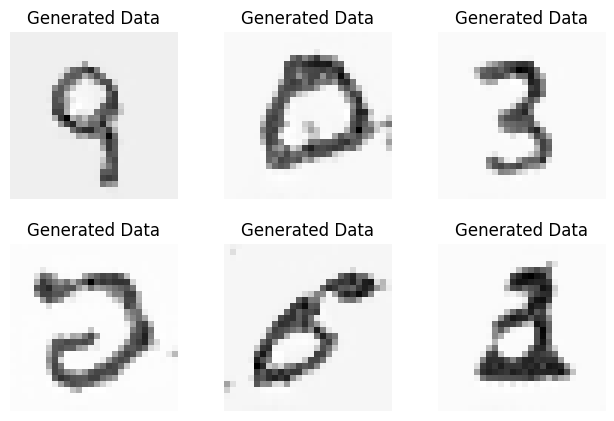

epoch 32


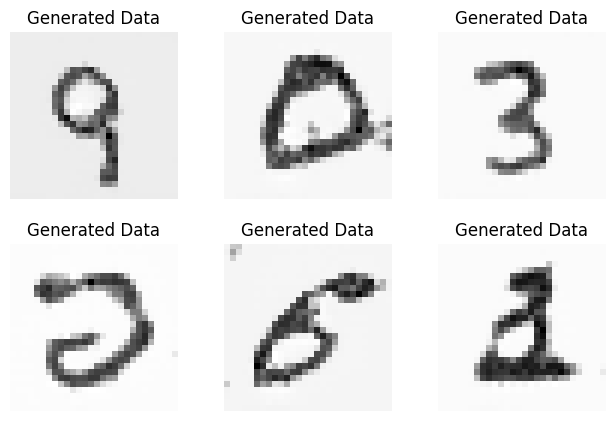

epoch 33


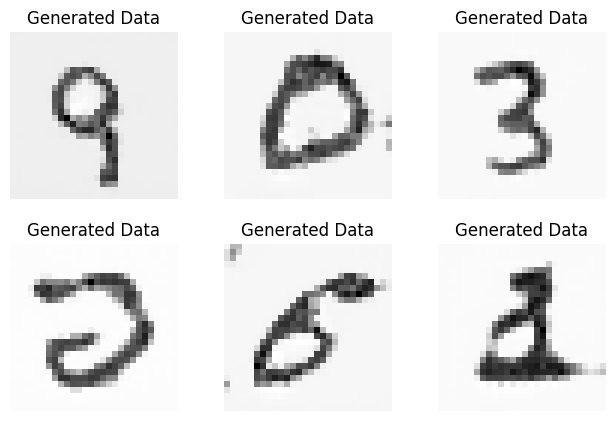

epoch 34


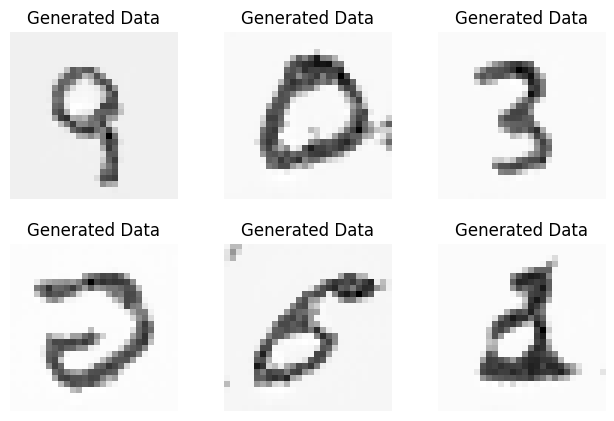

epoch 35


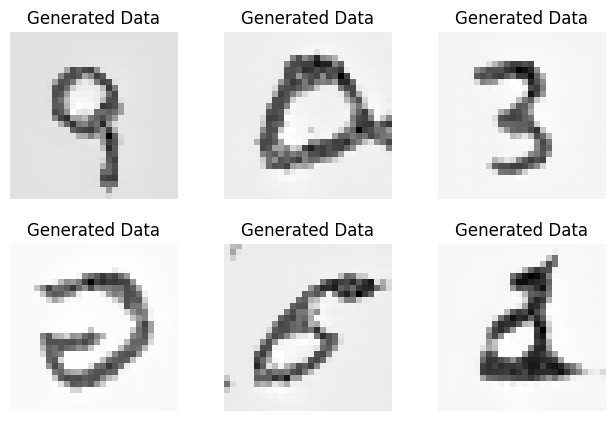

epoch 36


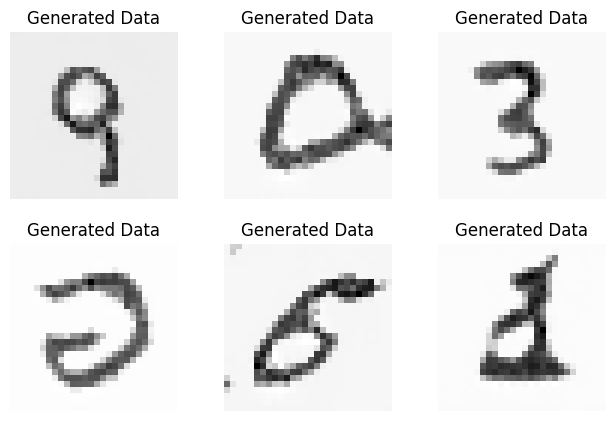

epoch 37


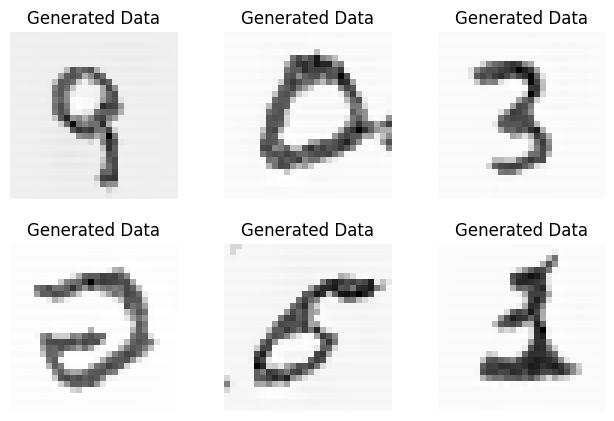

epoch 38


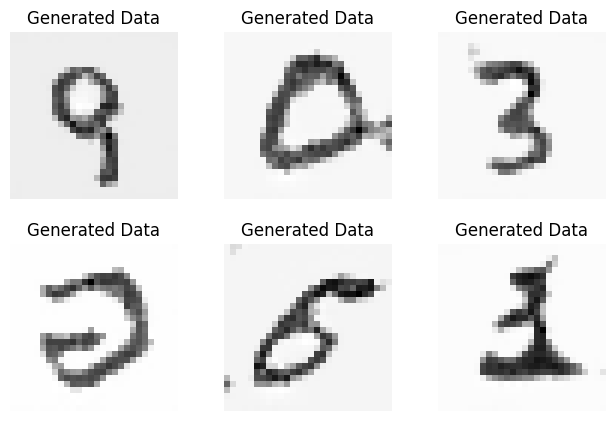

epoch 39


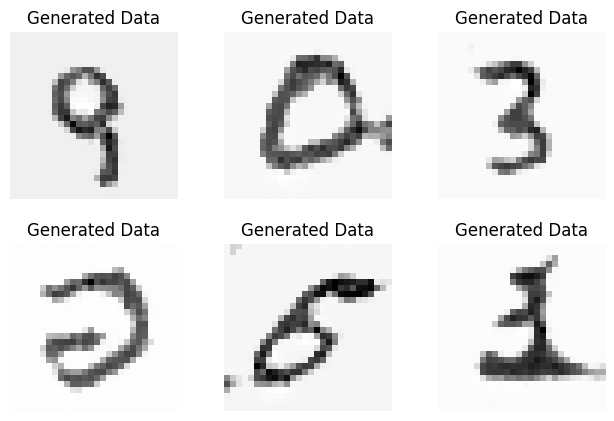

epoch 40


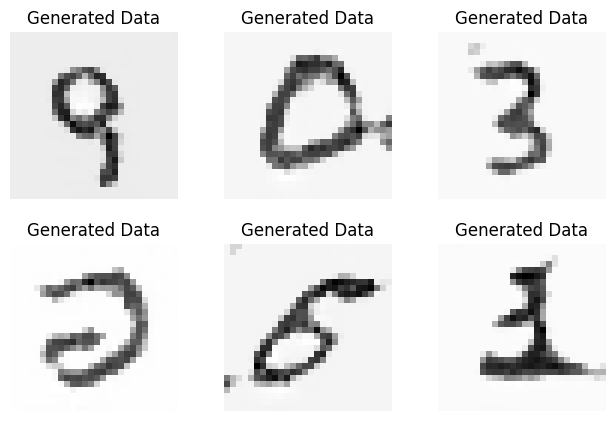

epoch 41


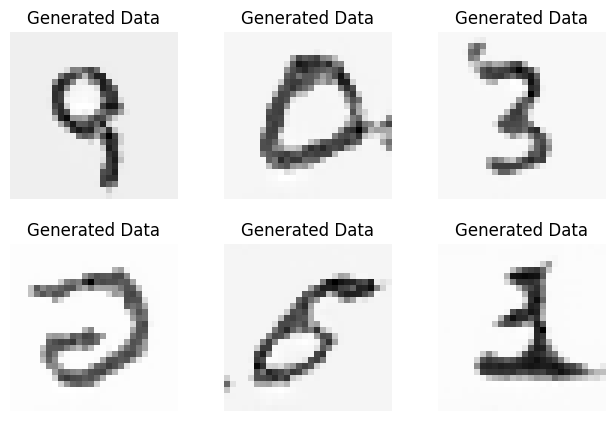

epoch 42


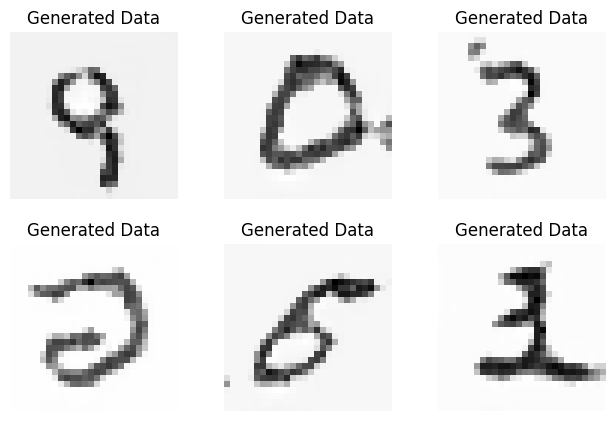

epoch 43


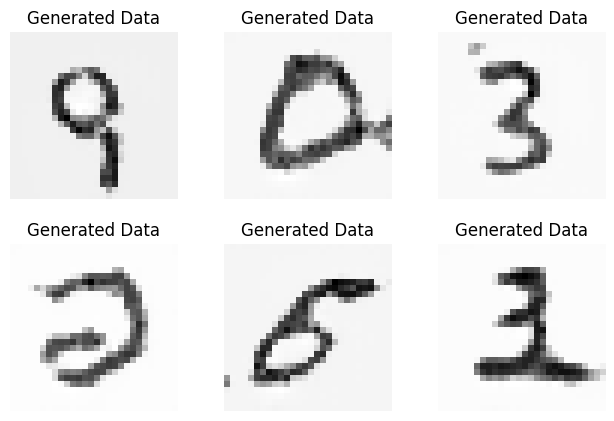

epoch 44


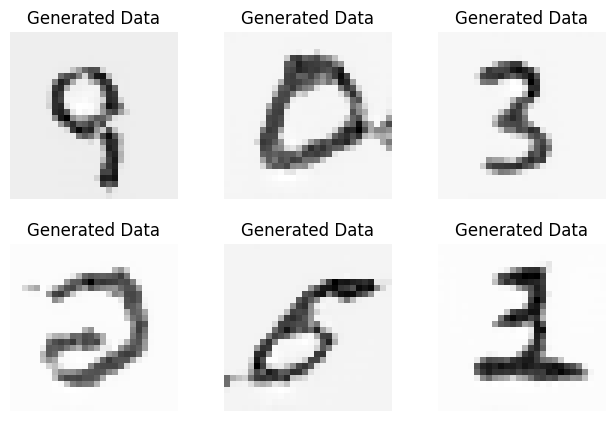

epoch 45


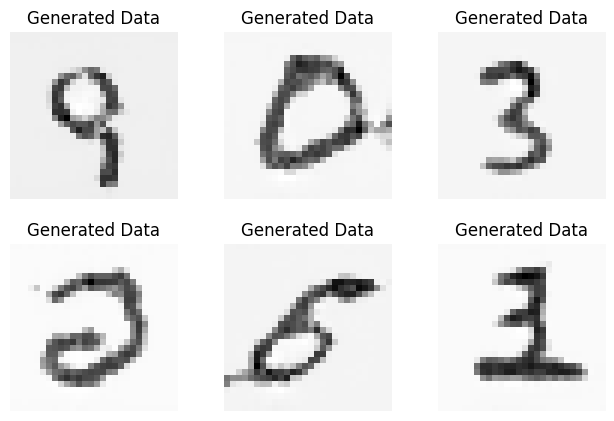

epoch 46


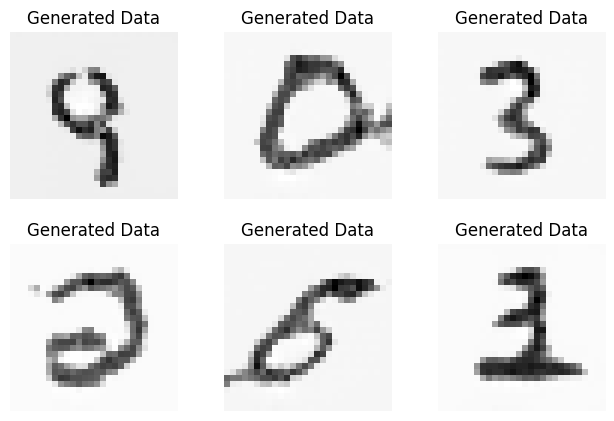

epoch 47


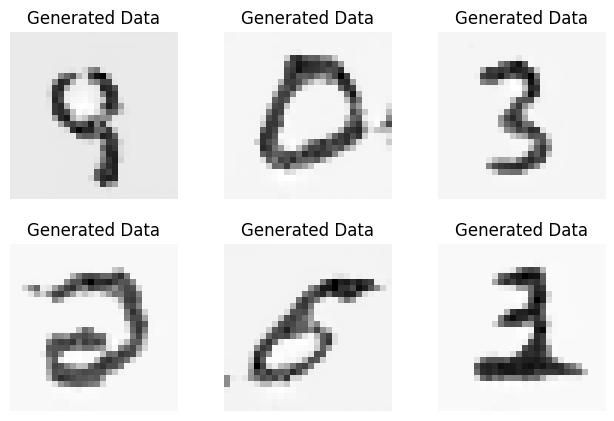

epoch 48


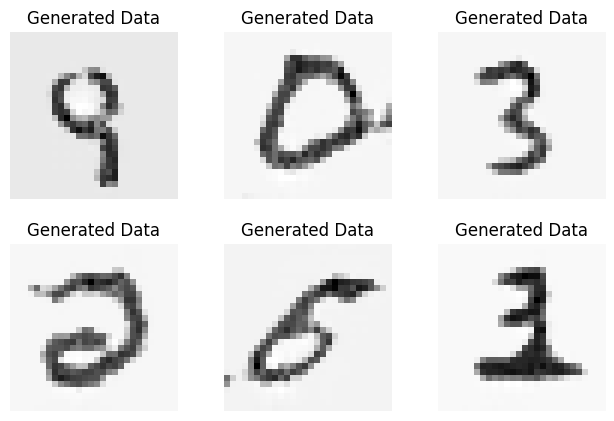

epoch 49


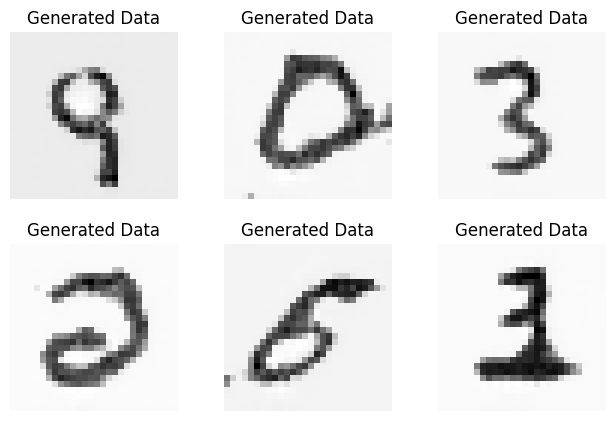

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [ ]:
trainer = pl.Trainer(max_epochs=50, devices =AVAIL_GPUS)
trainer.fit(model,dm)